In this notebook, you will find graphs representing results from simulations previously run, so you can compare your results with these

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from leap.simulation import Simulation
from leap.logger import get_logger

In [4]:
# setup the logger
logger = get_logger(__name__)

In [ ]:
# set output path to output/jupter folder in root
output_path = pathlib.Path("/home/me/pharmsci/leap/output/jupyter")
simulation = Simulation(min_year=2001, province="CA", population_growth_type="M3")
repr(simulation)

"Simulation(max_age=111, province='CA', min_year=2001, time_horizon=19, num_births_initial=100, population_growth_type='M3')"

In [6]:
# check if path exists before running
if not output_path.exists():
    raise Exception(f"Please input a correct output path.\nPath was <{output_path}>")

logger.message("Running simulation...")
outcome_matrix = simulation.run()
logger.message(outcome_matrix)
outcome_matrix.save(path=output_path)

### Figure 5. Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

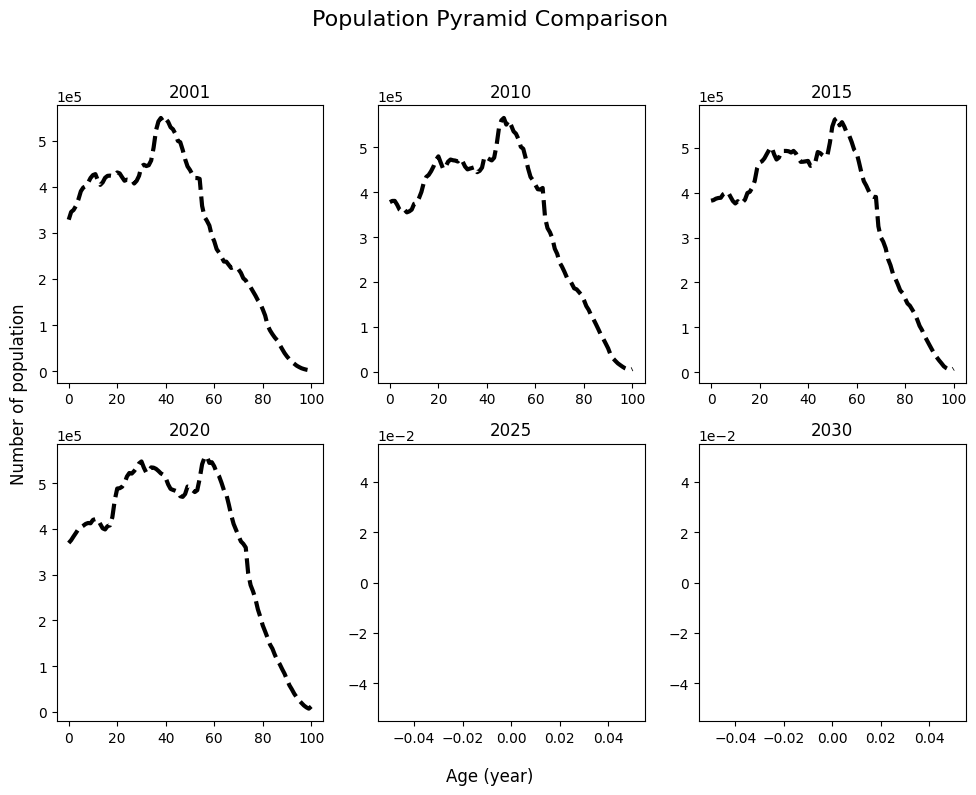

In [22]:
# Simulation parametres
chosen_province = "CA"
baseline_year = 2001
growth_type = "M3"

# Figure Parameters
num_cols = 3
num_rows = 2
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]

# Read in population data from StatsCanada
canada_pop_df = pd.read_csv("leap/processed_data/initial_pop_distribution.csv")
canada_pop_df = canada_pop_df.query("province == @chosen_province and year >= @baseline_year")
canada_pop_df.head()

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))

for i, year in enumerate(figure_years):
    ax = axs[i // num_cols][i % num_cols]
    year_data = canada_pop_df.query("year == @year")
    year_data_total = year_data.groupby("age").sum().reset_index()

    ax.plot(year_data_total["age"], year_data_total["n"], label="True",
            color="black", linestyle="dashed", linewidth=3)

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

fig.supxlabel("Age (year)")
fig.supylabel("Number of population")
fig.suptitle("Population Pyramid Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

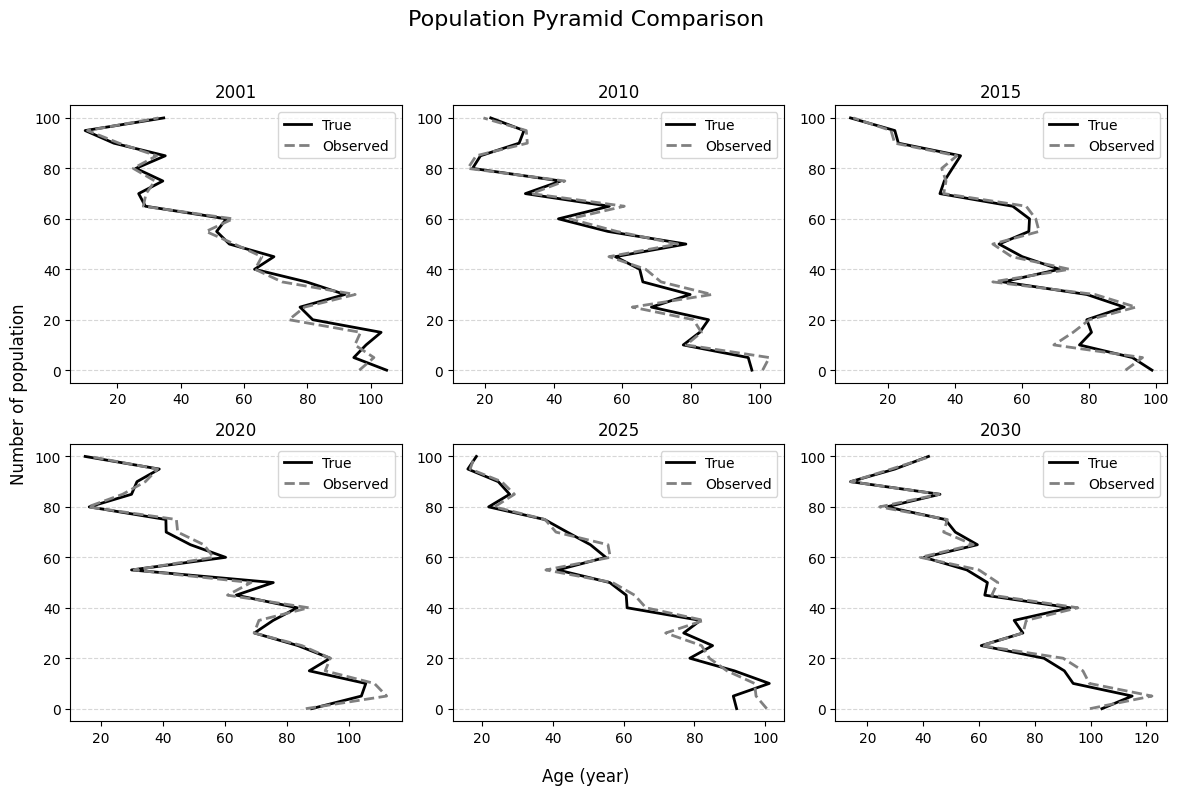

In [59]:
# Figure 5. Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

# Simulation Parameters

# Figure Parameters
num_cols = 3
num_rows = 2

np.random.seed(42)
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
ages = np.arange(0, 101, 5)

# Simulate "True" and "Observed" populations
true_population = {
    year: np.maximum(0, np.random.normal(100 - (ages * 0.8), 10)) for year in figure_years
}
observed_population = {
    year: np.maximum(0, true_population[year] * np.random.uniform(0.9, 1.1, len(ages))) for year in figure_years
}

# Make fake dataframe
infant_sex_data = []
for year in figure_years:
    for age, true_val, observed_val in zip(ages, true_population[year], observed_population[year]):
        infant_sex_data.append(
            {"Year": year, "Age": age, "True": true_val, "Observed": observed_val})

df = pd.DataFrame(infant_sex_data)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, year in enumerate(figure_years):
    ax = axs[i // num_cols][i % num_cols]
    year_data = df.query("Year == @year")

    ax.plot(year_data["True"], year_data["Age"], label="True",
            color="black", linestyle="solid", linewidth=2)
    ax.plot(year_data["Observed"], year_data["Age"], label="Observed",
            color="grey", linestyle="dashed", linewidth=2)

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.grid(axis='y', linestyle="--", alpha=0.5)
    ax.legend(loc="upper right")

fig.supxlabel("Age (year)")
fig.supylabel("Number of population")
fig.suptitle("Population Pyramid Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Figure 6. Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted), with the floor rate of 50 per 1,000 (purple).

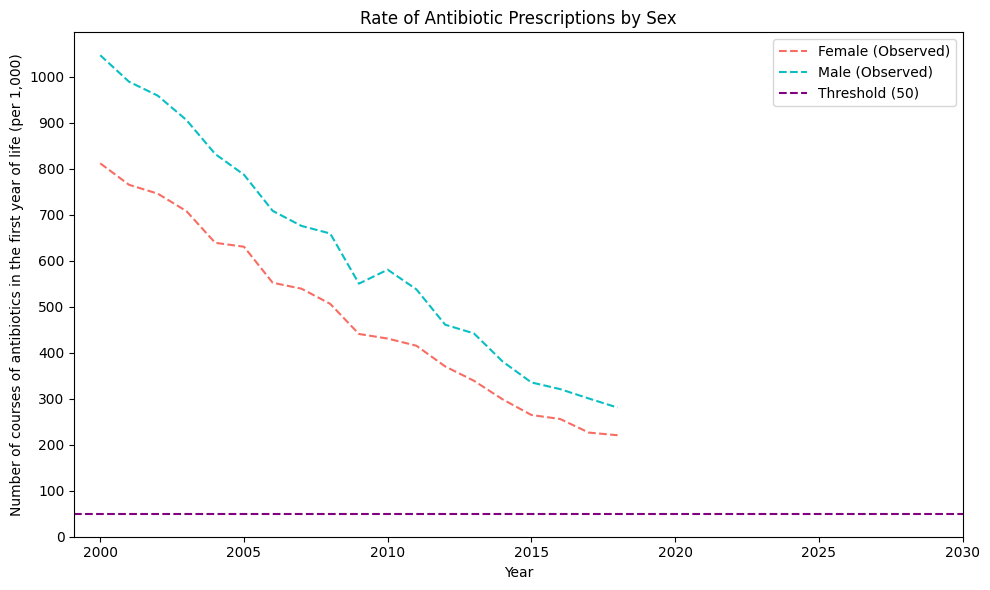

In [37]:
## Figure 6. Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted), with the floor rate of 50 per 1,000 (purple).

# Load target data
infant_data = pd.read_csv("leap/processed_data/InfantAbxBC.csv")

# Plotting
plt.figure(figsize=(10, 6))

# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}

# Dotted lines from count_data
for sex in infant_data['sex'].unique():
    infant_sex_data = infant_data[infant_data['sex'] == sex]
    plt.plot(
        infant_sex_data['year'],
        infant_sex_data['rate'],
        c=sex_colour_dict[sex],
        linestyle='dashed',
        label=f"{sex} (Observed)"
    )

# Additional elements
plt.axhline(y=50, color='purple', linestyle='dashed', label="Threshold (50)")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1,000)")
plt.xlabel("Year")
plt.xticks(range(infant_data['year'].min(), infant_data['year'].max() + 16, 5))
plt.yticks(range(0, 1100, 100))
plt.legend(title="")
plt.title("Rate of Antibiotic Prescriptions by Sex")

# Save the figure
plt.tight_layout()
plt.show()